#### Summary of Results

#### Key Findings: The "Recovery" Wasn't Equal
Winners: Older & More Educated Groups

Ages 50+ saw massive wealth gains: $237k (50-64) and $207k (65+) in net worth
College-educated groups maintained high wealth but changes weren't statistically significant
Some College education saw the biggest percentage boost: $299k net worth increase

Losers: Middle-Aged & Less Educated

Ages 35-49 (prime earning years): Income DROPPED by $7,363 despite no net worth change
No HS/HS Diploma only: Income declined by ~$3,400 each
These groups are earning less but not building wealth

Young Adults (18-34): Small Gains

Net worth up only $10,478 (from very low base of $12k)
Still far behind other age groups in absolute terms
Income up slightly ($2,115) but still struggling

Debt Patterns

Ages 35-49: Debt down $18k (deleveraging during tough times)
Ages 50-64: Debt UP $13k (possibly tapping equity/credit)
College grads: Debt down $81k (paying off loans or downsizing)

#### Bottom Line
The 2019-2022 period (covering COVID) created a K-shaped recovery: older, already-wealthy households with some college+ education saw significant asset appreciation, while middle-aged and less-educated workers saw incomes stagnate or decline. The wealth gap widened along both age and education lines.

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns


In [2]:
data2019 = pd.read_csv("data/2019.csv")
data2022 = pd.read_csv("data/2022.csv")
data2019.head()
data2022.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,3027.956120,2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,2,1
1,1,12,3054.900065,2,70,5,9,3,2,2,...,4,2,5,2,1,8,3,3,2,1
2,1,13,3163.637766,2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,1,1
3,1,14,3166.228463,2,70,5,9,3,2,2,...,3,2,4,1,1,6,3,2,1,1
4,1,15,3235.624715,2,70,5,9,3,2,2,...,3,2,4,2,1,8,3,3,1,1


STATISTICAL SIGNIFICANCE ANALYSIS: 2019 vs 2022


ANALYZING: NETWORTH


--- AGE ---
Category   Median_2019  Median_2022  Median_Change      P_Value Significant  Effect_Size
   18-34  12322.352318      22800.0   10477.647682 4.114787e-23         Yes     0.134723
   35-49 169869.944370     178500.0    8630.055630 2.336232e-01          No     0.012097
   50-64 547579.602650     785262.5  237682.897350 1.609148e-04         Yes     0.034008
     65+ 838105.430460    1045100.0  206994.569540 1.725076e-07         Yes     0.050009

✓ SIGNIFICANT changes found in: 18-34, 50-64, 65+

--- HHSEX ---

--- EDUC ---
      Category  Median_2019  Median_2022  Median_Change      P_Value Significant  Effect_Size
 No HS Diploma 6.839311e+04      65042.5  -3.350613e+03 5.162890e-01          No     0.006118
    HS Diploma 1.206907e+05     144310.0   2.361934e+04 8.279825e-06         Yes     0.047784
  Some College 8.806483e+05    1179252.5   2.986042e+05 7.550252e-14         Yes     0.061171
College Degree 

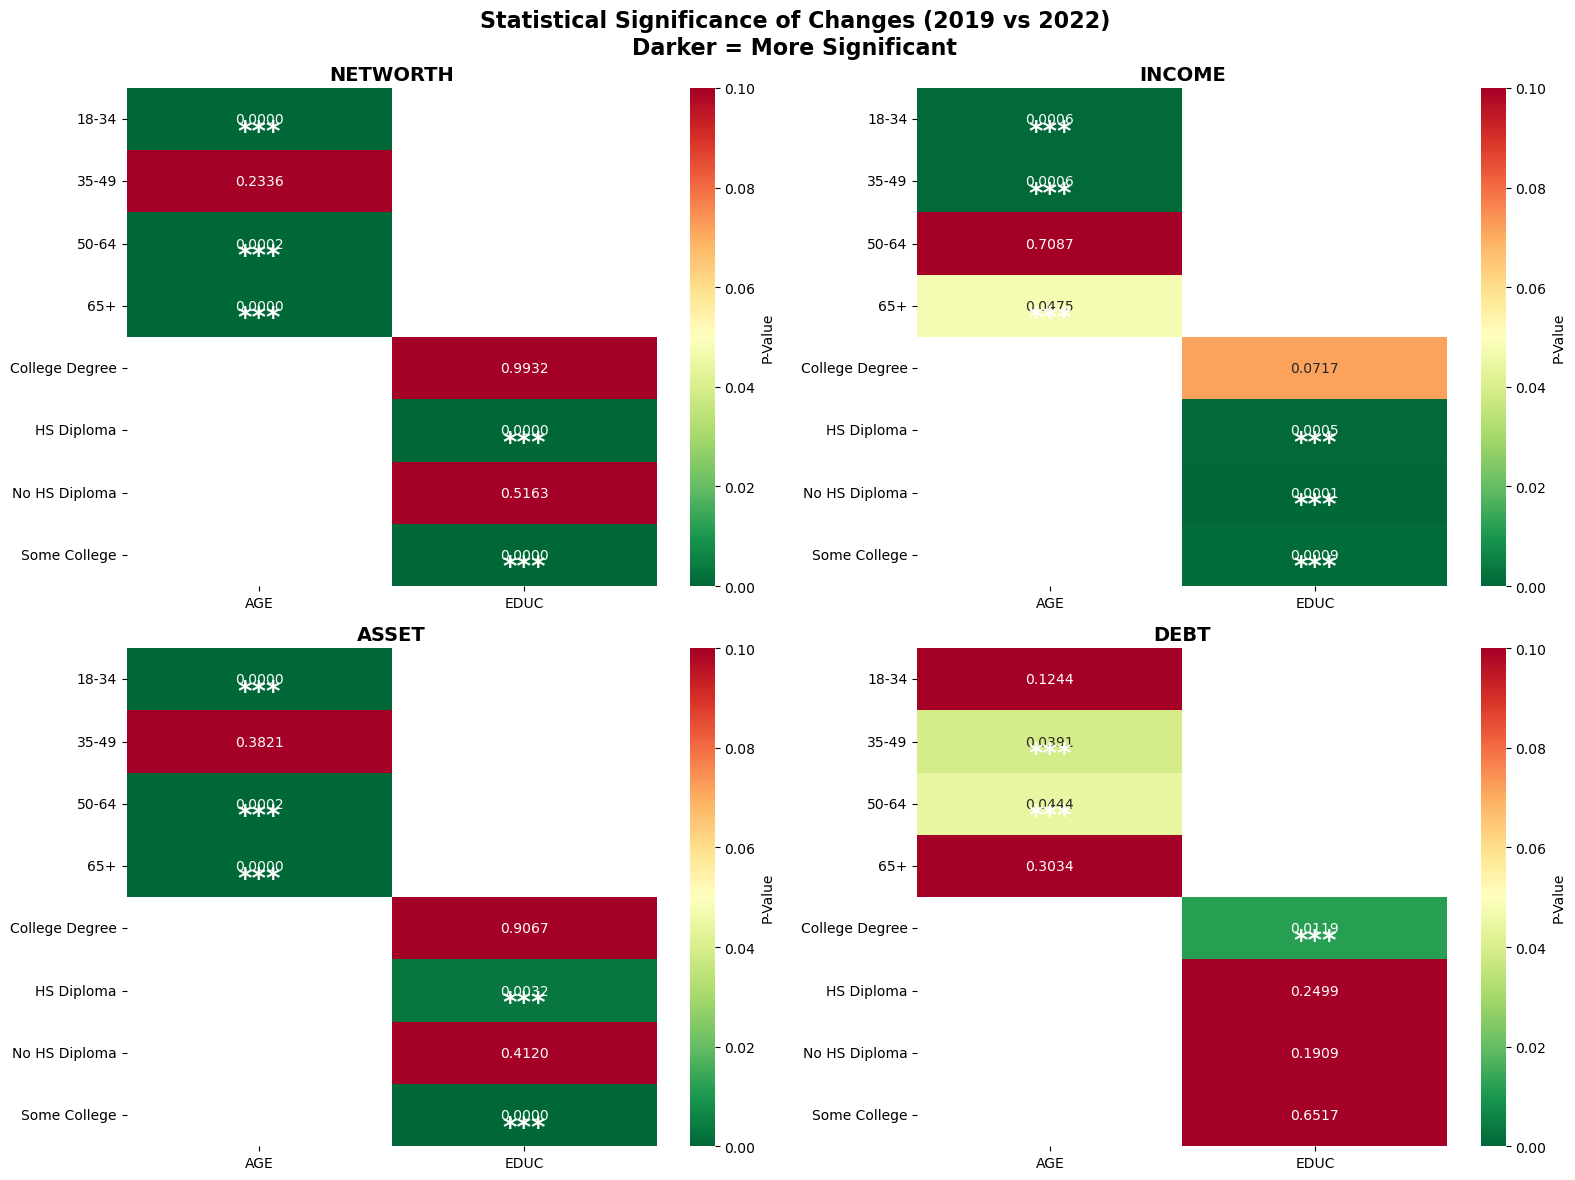

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data2019 = pd.read_csv("data/2019.csv")
data2022 = pd.read_csv("data/2022.csv")

# Add year column for identification
data2019['YEAR'] = 2019
data2022['YEAR'] = 2022

# Combine datasets
combined_data = pd.concat([data2019, data2022], ignore_index=True)

# Define metrics to analyze
metrics = ['NETWORTH', 'INCOME', 'ASSET', 'DEBT']

# ==============================================================================
# FUNCTION: Create Age Groups
# ==============================================================================
def create_age_groups(df):
    """Create age group categories"""
    df = df.copy()
    df['AGE_GROUP'] = pd.cut(df['AGE'], 
                              bins=[0, 34, 49, 64, 100], 
                              labels=['18-34', '35-49', '50-64', '65+'])
    return df

# ==============================================================================
# FUNCTION: Create Education Groups
# ==============================================================================
def create_education_groups(df):
    """Create education level categories"""
    df = df.copy()
    conditions = [
        df['EDUC'] <= 8,
        (df['EDUC'] > 8) & (df['EDUC'] <= 11),
        (df['EDUC'] > 11) & (df['EDUC'] <= 13),
        df['EDUC'] > 13
    ]
    labels = ['No HS Diploma', 'HS Diploma', 'Some College', 'College Degree']
    df['EDUC_GROUP'] = np.select(conditions, labels, default='Unknown')
    # Replace 'Unknown' with NaN for consistency
    df['EDUC_GROUP'] = df['EDUC_GROUP'].replace('Unknown', np.nan)
    return df

# ==============================================================================
# FUNCTION: Mann-Whitney U Test (for 2 groups)
# ==============================================================================
def mann_whitney_test(group1, group2, metric_name):
    """
    Performs Mann-Whitney U test to compare two independent groups.
    Use this for non-normal distributions (common in wealth data).
    """
    # Remove NaN and infinite values
    g1 = group1.dropna()
    g2 = group2.dropna()
    g1 = g1[np.isfinite(g1)]
    g2 = g2[np.isfinite(g2)]
    
    if len(g1) < 3 or len(g2) < 3:
        return None, None, None
    
    statistic, p_value = mannwhitneyu(g1, g2, alternative='two-sided')
    
    # Calculate effect size (rank-biserial correlation)
    n1, n2 = len(g1), len(g2)
    effect_size = 1 - (2*statistic) / (n1 * n2)
    
    return statistic, p_value, effect_size

# ==============================================================================
# FUNCTION: Kruskal-Wallis Test (for 3+ groups)
# ==============================================================================
def kruskal_wallis_test(groups_dict, metric_name):
    """
    Performs Kruskal-Wallis H test for 3+ independent groups.
    Non-parametric alternative to one-way ANOVA.
    """
    # Prepare groups
    clean_groups = []
    for group_data in groups_dict.values():
        g = group_data.dropna()
        g = g[np.isfinite(g)]
        if len(g) >= 3:
            clean_groups.append(g)
    
    if len(clean_groups) < 2:
        return None, None
    
    statistic, p_value = kruskal(*clean_groups)
    
    return statistic, p_value

# ==============================================================================
# FUNCTION: Comprehensive Statistical Analysis
# ==============================================================================
def analyze_demographic_changes(df, metric, demographic):
    """
    Analyzes whether changes in a metric differ significantly across demographics
    """
    results = []
    
    # Prepare demographic groups
    if demographic == 'AGE':
        df = create_age_groups(df)
        demo_col = 'AGE_GROUP'
        categories = ['18-34', '35-49', '50-64', '65+']
    elif demographic == 'HHSEX':
        demo_col = 'HHSEX'
        categories = [1, 2]  # Male, Female
        df[demo_col] = df[demo_col].replace({1: 'Male', 2: 'Female'})
    elif demographic == 'EDUC':
        df = create_education_groups(df)
        demo_col = 'EDUC_GROUP'
        categories = ['No HS Diploma', 'HS Diploma', 'Some College', 'College Degree']
    elif demographic == 'MARRIED':
        demo_col = 'MARRIED'
        categories = [1, 2]
        df[demo_col] = df[demo_col].replace({1: 'Married', 2: 'Not Married'})
    else:
        return pd.DataFrame()
    
    # For each demographic category, compare 2019 vs 2022
    for category in categories:
        subset = df[df[demo_col] == category]
        
        data_2019 = subset[subset['YEAR'] == 2019][metric]
        data_2022 = subset[subset['YEAR'] == 2022][metric]
        
        # Calculate descriptive statistics
        median_2019 = data_2019.median()
        median_2022 = data_2022.median()
        mean_2019 = data_2019.mean()
        mean_2022 = data_2022.mean()
        
        # Perform Mann-Whitney U test
        stat, p_value, effect_size = mann_whitney_test(data_2019, data_2022, metric)
        
        if p_value is not None:
            results.append({
                'Demographic': demographic,
                'Category': category,
                'Metric': metric,
                'Median_2019': median_2019,
                'Median_2022': median_2022,
                'Median_Change': median_2022 - median_2019,
                'Mean_2019': mean_2019,
                'Mean_2022': mean_2022,
                'Mean_Change': mean_2022 - mean_2019,
                'P_Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No',
                'Effect_Size': effect_size,
                'N_2019': len(data_2019.dropna()),
                'N_2022': len(data_2022.dropna())
            })
    
    return pd.DataFrame(results)

# ==============================================================================
# RUN ANALYSIS FOR ALL DEMOGRAPHICS AND METRICS
# ==============================================================================
print("=" * 80)
print("STATISTICAL SIGNIFICANCE ANALYSIS: 2019 vs 2022")
print("=" * 80)

all_results = []

for metric in metrics:
    print(f"\n\n{'='*80}")
    print(f"ANALYZING: {metric}")
    print(f"{'='*80}\n")
    
    for demographic in ['AGE', 'HHSEX', 'EDUC', 'MARRIED']:
        print(f"\n--- {demographic} ---")
        
        results_df = analyze_demographic_changes(combined_data, metric, demographic)
        
        if not results_df.empty:
            all_results.append(results_df)
            
            # Display results
            display_cols = ['Category', 'Median_2019', 'Median_2022', 'Median_Change', 
                           'P_Value', 'Significant', 'Effect_Size']
            print(results_df[display_cols].to_string(index=False))
            
            # Interpretation
            sig_groups = results_df[results_df['Significant'] == 'Yes']['Category'].tolist()
            if sig_groups:
                print(f"\n✓ SIGNIFICANT changes found in: {', '.join(map(str, sig_groups))}")
            else:
                print(f"\n✗ No statistically significant changes found")

# ==============================================================================
# COMBINE ALL RESULTS
# ==============================================================================
if all_results:
    final_results = pd.concat(all_results, ignore_index=True)
    
    # Save to CSV
    final_results.to_csv('statistical_significance_results.csv', index=False)
    print("\n\n" + "="*80)
    print("Results saved to: statistical_significance_results.csv")
    print("="*80)
    
    # Summary statistics
    print("\n\n" + "="*80)
    print("SUMMARY: Statistically Significant Changes (p < 0.05)")
    print("="*80)
    
    sig_results = final_results[final_results['Significant'] == 'Yes']
    
    if not sig_results.empty:
        summary = sig_results.groupby(['Metric', 'Demographic']).size().reset_index(name='Count')
        print(summary.to_string(index=False))
        
        print("\n\nDETAILED SIGNIFICANT FINDINGS:")
        for _, row in sig_results.iterrows():
            direction = "INCREASED" if row['Median_Change'] > 0 else "DECREASED"
            print(f"\n• {row['Metric']} {direction} for {row['Demographic']}={row['Category']}")
            print(f"  Change: ${row['Median_Change']:,.0f} (p={row['P_Value']:.4f})")
            print(f"  Effect size: {row['Effect_Size']:.3f}")
    else:
        print("\nNo statistically significant changes detected at p < 0.05 level.")

# ==============================================================================
# VISUALIZATION: P-VALUES HEATMAP
# ==============================================================================
if all_results:
    final_results = pd.concat(all_results, ignore_index=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Statistical Significance of Changes (2019 vs 2022)\nDarker = More Significant', 
                 fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # Prepare pivot table for heatmap
        metric_data = final_results[final_results['Metric'] == metric]
        pivot_data = metric_data.pivot_table(
            values='P_Value', 
            index='Category', 
            columns='Demographic',
            aggfunc='first'
        )
        
        # Create heatmap (lower p-value = darker color)
        sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn_r', 
                   center=0.05, vmin=0, vmax=0.10, ax=ax,
                   cbar_kws={'label': 'P-Value'})
        ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Add significance markers
        for i, category in enumerate(pivot_data.index):
            for j, demo in enumerate(pivot_data.columns):
                p_val = pivot_data.iloc[i, j]
                if pd.notna(p_val) and p_val < 0.05:
                    ax.text(j + 0.5, i + 0.7, '***', ha='center', va='center',
                           color='white', fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('significance_heatmap.png', dpi=300, bbox_inches='tight')
    print("\n\nVisualization saved to: significance_heatmap.png")
    print("*** = Statistically significant at p < 0.05")

print("\n\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)